<a href="https://colab.research.google.com/github/pk2971/Air-Quality-vs-Temperature-time-series/blob/main/RFM_analysis_score_LTV_Customer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np


In [101]:
df=pd.read_csv('OnlineRetail.csv',engine='python',encoding= 'unicode_escape',parse_dates = ['InvoiceDate'])

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The features we need are CustomerID, UnitPrice, Quantity and InvoiceDate.

Revenue=Active customer count * Order Count * Average Revenue per order

We will create a new data frame for the revenue and the invoice date and month

In [103]:
df['Revenue']=df['UnitPrice']*df['Quantity']
df['YearMonth']=df['InvoiceDate'].map(lambda date: 100*date.year + date.month)


In [104]:
df_revenue = df.groupby(['YearMonth'])['Revenue'].sum().reset_index()
#Created a new data frame for analysis

In [105]:
df_revenue

,YearMonth,Revenue
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


In [106]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import plotly.offline as pyoff
import plotly.graph_objs as go
plot_data = [
    go.Scatter(
        x=df_revenue['YearMonth'],
        y=df_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

RFM Clustering of the customers

Lower recency indicates better customers.

In [107]:
#Finding Recency
df_user=pd.DataFrame()
df_user['CustomerID']=pd.DataFrame(df['CustomerID'].unique())

df_max_purchase = pd.DataFrame(df.groupby('CustomerID').InvoiceDate.max().reset_index())
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

df_user=pd.merge(df_user, df_max_purchase[['CustomerID','Recency']], on='CustomerID')
#Would have been sm easier on SQL




In [108]:
df_user.Recency.describe()

count    4372.000000
mean       91.047118
std       100.765435
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

K Means clustering to assign Recency Scores to the customers.

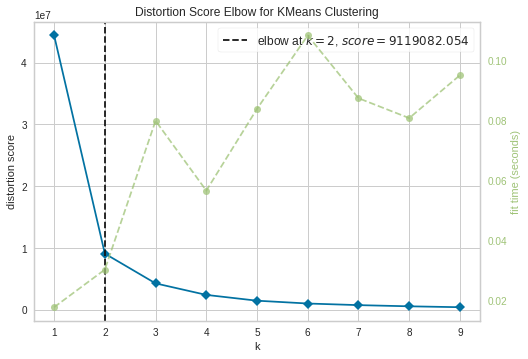

In [109]:
#Elbow visualizer to find the K value for K-Means Model
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
X=df_user[['Recency']]
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X)
visualizer.show()


Even though 3 seems optimal, we want to segment customers into 4 recency clusters. Therefore we will be selecting k=4.

In [110]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [111]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2167.0,17.538533,13.320860,0.0,6.0,16.0,28.00,48.0
1,627.0,189.451356,32.948533,135.0,161.0,187.0,217.00,249.0
2,506.0,308.851779,39.144563,250.0,274.0,305.0,350.75,373.0
3,1072.0,79.278918,23.875838,49.0,59.0,73.0,95.00,134.0


In [112]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [113]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,506.0,308.851779,39.144563,250.0,274.0,305.0,350.75,373.0
1,627.0,189.451356,32.948533,135.0,161.0,187.0,217.00,249.0
2,1072.0,79.278918,23.875838,49.0,59.0,73.0,95.00,134.0
3,2167.0,17.538533,13.320860,0.0,6.0,16.0,28.00,48.0


We will find the frequency using total number of orders from customers and assign frequency clusters.

Higher frequency indicates better customers.

In [114]:
df_frequency = pd.DataFrame(df.groupby('CustomerID').InvoiceDate.count().reset_index())
df_frequency.columns = ['CustomerID','Frequency']



In [115]:
df_user = pd.merge(df_user, df_frequency, on='CustomerID')


In [116]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4372 non-null   float64
 1   Recency         4372 non-null   int64  
 2   RecencyCluster  4372 non-null   int64  
 3   Frequency       4372 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 170.8 KB


In [120]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

In [121]:
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3862.0,49.753755,44.812998,1.0,15.0,34.0,73.0,189.0
1,482.0,329.107884,132.670589,190.0,228.0,286.0,393.5,803.0
2,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0
3,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0


Revenue/Monetary value for customers.

Higher the revenue, the more important the customer is.

In [124]:
#Sum of all the revenue grouped by CustomerID
df_revenue = df.groupby('CustomerID').Revenue.sum().reset_index()
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

In [126]:
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

In [ ]:
df_user.groupby('RevenueCluster')['Revenue'].describe()

We reduce the features now by adding up all the clustering score for the customers.

In [128]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']


In [129]:
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

<ipython-input-129-eb3b2f83d9f5>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,308.875000,22.273810,343.315179
1,190.017713,32.996779,538.352208
2,80.240116,46.644166,915.911149
3,20.551163,70.611628,1256.672396
4,13.252577,306.242268,4426.578608
5,7.126582,518.278481,14246.767595
6,8.636364,955.909091,44249.222727
7,2.555556,2432.555556,98056.746667
8,1.333333,4372.000000,156394.183333


Customers with overall score 8 is the best score and are important customers.

We want to make things simpler and bucket the overall score further into categories.

In [130]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 

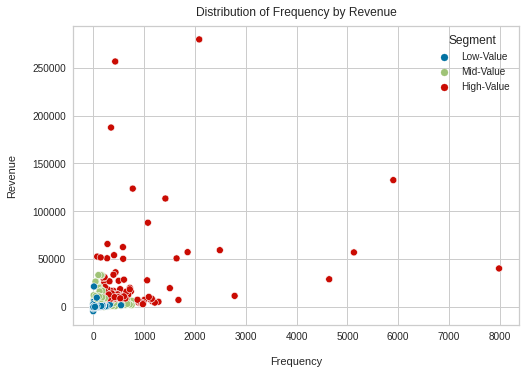

In [141]:
sns.scatterplot(x=df_user['Frequency'],y=df_user['Revenue'],hue=df_user['Segment'])
plt.xlabel("Frequency", labelpad=15)
plt.ylabel("Revenue", labelpad=15)
plt.title("Distribution of Frequency by Revenue", y=1.013);

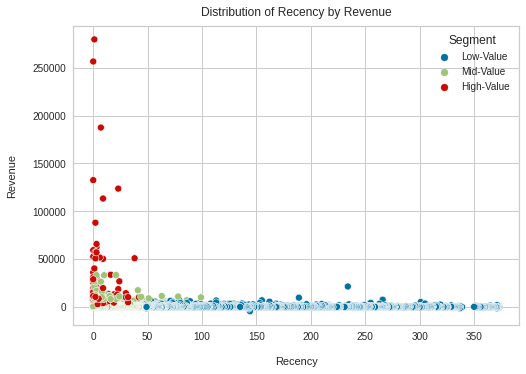

In [143]:
sns.scatterplot(x=df_user['Recency'],y=df_user['Revenue'],hue=df_user['Segment'])
plt.xlabel("Recency", labelpad=15)
plt.ylabel("Revenue", labelpad=15)
plt.title("Distribution of Recency by Revenue", y=1.013);

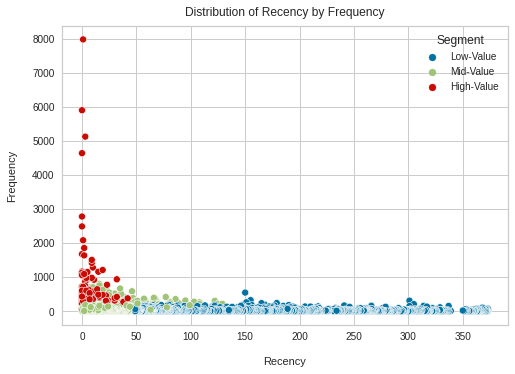

In [144]:
sns.scatterplot(x=df_user['Recency'],y=df_user['Frequency'],hue=df_user['Segment'])
plt.xlabel("Recency", labelpad=15)
plt.ylabel("Frequency", labelpad=15)
plt.title("Distribution of Recency by Frequency", y=1.013);